# [LAB-12] 2. 회귀분석의 가정 검정 (사후검정)

'fit' 객체 안에는 무수한 프로퍼티들 많고

사후검정 때 이 기능들 많이 쓸 예정

잔차의 선형성 검증

논리: x-y가 선형성이 아니면 잔차도 선형성이 아니다

by: 잔차에 대한 산점도+추세선 그려서(regplot) 잔차의 추세선이 '선형성'을 가지는지 확인

1. 그래프 그리기:
-> 관련 regplot 파라미터: `lowess=True`
2. 통계량 검정: Ramsey RESET Test
-> 관련 파라미터: `linear_reset`
3. 잔차의 정규성 검정
by: zscore값 구한 후 Q-Q plot으로 시각화
4. 잔차도(: 잔차의 분산 MSE, Mean Squared Error of residuals) 검정
   1. 3MSE = ±3root(MSE) 범위 내에 잔차의 99%,
   2. 2MSE = ±2root(MSE) 범위 내에 잔차의 68%,
   3. 1MSE = ±root(MSE) 범위 내에 잔차의 59%,가 들어있어야됨
   4. 이 기능은 머신러닝엔 없어서 머신러닝 가서는 수식 일일히 적어야됨
   5. -> 관련 파라미터: `resiplot` in seaborn
      1. 컴터가 해석하는 `.text()`에서 x, y축의 범위는 시작점:0, 끝점:1

선형회귀분석의 가정 / 기준값 / 방법 / if 위배:
1. 선형성 / p > 0.05 / Ramsey RESET Test / or regplot(lowess_True) 시각화 / 변수변환(log, sqrt) 또는 파생변수(x²) 사용
2. 잔차의 정규성 / MSE범위 / Q-Q plot 시각화(zscore) / Y 변환(표본>30이면 무시)
3. 등분산성 / p > 0.05 / Breusch-Pegan Test / Y 변환(표본>30이면 무시)
4. 독립성 / Durbin-Watson값 / 회귀분석 수행결과표 / 추세·시간변수 추가(무시해도 ㄱㅊ)

## #01. 준비작업

### 1. 패키지 참조:

In [2]:
# 기본 참조
from hossam import load_data
from pandas import DataFrame, melt
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from itertools import combinations

# 선형회귀용 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 사후검정용 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, kstest, pearsonr, spearmanr
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

### 2. 그래프 시각화:

In [3]:
my_dpi = 200  # 이미지 선명도 (100~300)
font_path = r"\Users\itwill\OneDrive\문서\학원수업\NotoSansKR-Regular.ttf"  # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)      # 폰트 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname = font_path)    # 폰트 속성을 읽어옴
font_name = font_prop.get_name()    # 읽어온 속성에서 폰트의 이름만 추출

plt.rcParams['font.family'] = font_name # 그래프에 한글폰트 적용
plt.rcParams['font.size'] = 6          # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False  
    # 그래프에 마이너스 깨짐 방지 (한글 환경에선 필수)

### 3. 데이터 불러오기:

In [4]:
origin = load_data('cars')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab12_/cars.xlsx
[desc] 자동차의 속도(speed)에 따른 제동거리(dist) 조사 데이터 (출처: R 기본 데이터)

field    description
-------  -------------
speed    속도
dist     제동거리


===== 데이터 크기 확인 =====
데이터셋 크기: (50, 2)
열 갯수: 2
행 갯수: 50

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   speed   50 non-null     int64
 1   dist    50 non-null     int64
dtypes: int64(2)
memory usage: 932.0 bytes
None


,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16


## #02. 단순선형회귀

In [5]:
yname = 'dist'

x = origin.drop(yname, axis = 1)
y = origin[yname]
X = sm.add_constant(x)

fit = sm.OLS(y, X).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     89.57
Date:                Thu, 11 Dec 2025   Prob (F-statistic):           1.49e-12
Time:                        16:03:04   Log-Likelihood:                -206.58
No. Observations:                  50   AIC:                             417.2
Df Residuals:                      48   BIC:                             421.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.5791      6.758     -2.601      0.0

## #03. 잔차 분석 (=회귀분석의 가정)

### 1. 잔차 구하기

#### 1) 예측값(y_pred) 얻기

by: 샘플 외 새 입력값으로 구할 때:

In [6]:
y_pred = fit.predict(X)
y_pred.head()

0    -1.849460
1    -1.849460
2     9.947766
3     9.947766
4    13.880175
dtype: float64

by: **회귀분석 결과 객체 안에 내장되어있는 예측값 부를 때:**

In [7]:
y_pred = fit.fittedvalues
y_pred.head()

0    -1.849460
1    -1.849460
2     9.947766
3     9.947766
4    13.880175
dtype: float64

#### 2) 잔차(residual) 계산

by: 얻은 예측값으로 직접 계산할 때:

In [8]:
residual = origin['dist'] - y_pred
residual.head()

0     3.849460
1    11.849460
2    -5.947766
3    12.052234
4     2.119825
dtype: float64

by: **회귀분석 결과 객체 안에 내장되어있는 잔차값 부를 때:**

In [9]:
residual = fit.resid
residual.head()

0     3.849460
1    11.849460
2    -5.947766
3    12.052234
4     2.119825
dtype: float64

#### 3) 분석 데이터에 결합:

In [10]:
df = origin.copy()
df['y_pred'] = y_pred
df['resid'] = residual
df.head()

,speed,dist,y_pred,resid
0,4,2,-1.849460,3.849460
1,4,10,-1.849460,11.849460
2,7,4,9.947766,-5.947766
3,7,22,9.947766,12.052234
4,8,16,13.880175,2.119825


### 2. 잔차 선형성 검정

#### 1) 시각화를 통한 검정:

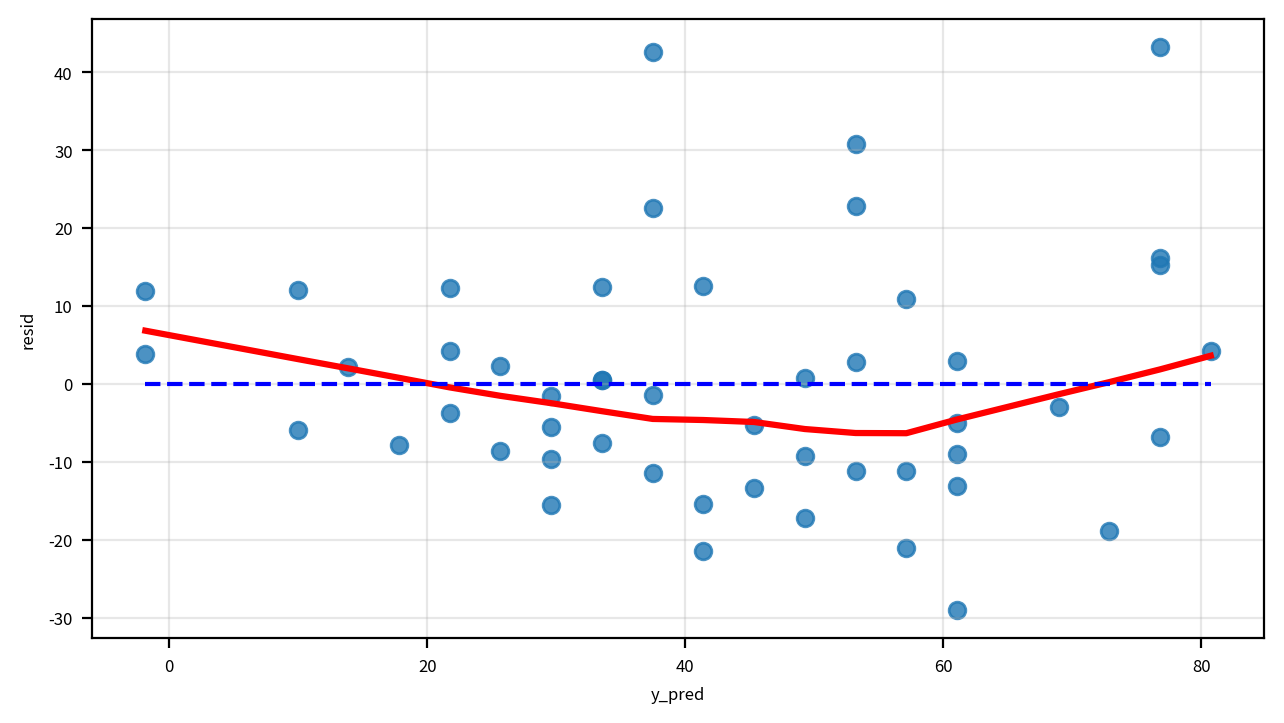

In [12]:
xmin = df['y_pred'].min()
xmax = df['y_pred'].max()
xrange = [xmin, xmax]
yrange = [0, 0]

# 1) 그래프 초기화
width_px = 1280             # 그래프 가로 크기
height_px = 720             # 그래프 세로 크기
rows = 1                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) Reg Plot 그리기 
# 잔차선:
sb.regplot(data = df, x = 'y_pred', y = 'resid',
           lowess = True, line_kws = {'color': 'red'})
# 회귀선(추세선):
sb.lineplot(x=xrange, y=yrange, color='blue', linestyle='--')

# 3) 그래프 꾸미기: 
ax.grid(True, alpha=0.3)     # 배경, 격자 표시/숨김

# 4) 출력
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

>겁나 곡선이네.. 통계값 ㄱㄱ

#### 2) 통계량을 통한 검정 - Ramsey RESET Test:

In [13]:
reset_resid = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_resid.fvalue:.4f}")
print(f"p-value: {reset_resid.pvalue:.4f}")

if reset_resid.pvalue < 0.05:
    print("선형성/기능형 위배 가능성 존재 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 2.2960
p-value: 0.1364
선형성 가정 위배 근거 없음 (5% 유의수준)


### 3. 잔차 정규성 검정

#### 1) 시각화를 통한 검정

- **Q-Q Plot: zscore에 대한 산점도 그래프**

**zscore 구하기:**

In [14]:
df['zscore'] = zscore(df['y_pred'])
df.head()

,speed,dist,y_pred,resid,zscore
0,4,2,-1.849460,3.849460,-2.177858
1,4,10,-1.849460,11.849460,-2.177858
2,7,4,9.947766,-5.947766,-1.604738
3,7,22,9.947766,12.052234,-1.604738
4,8,16,13.880175,2.119825,-1.413697


**Q-Q 플롯 좌표 생성:**

In [15]:
(x, y), _ = probplot(df['zscore'])
display(x[:5])
display(y[:5])

array([-2.20385432, -1.83293478, -1.61402323, -1.45296849, -1.32267759])

array([-2.17785805, -2.17785805, -1.60473751, -1.60473751, -1.41369733])

**Q-Q 플롯 그리기:**

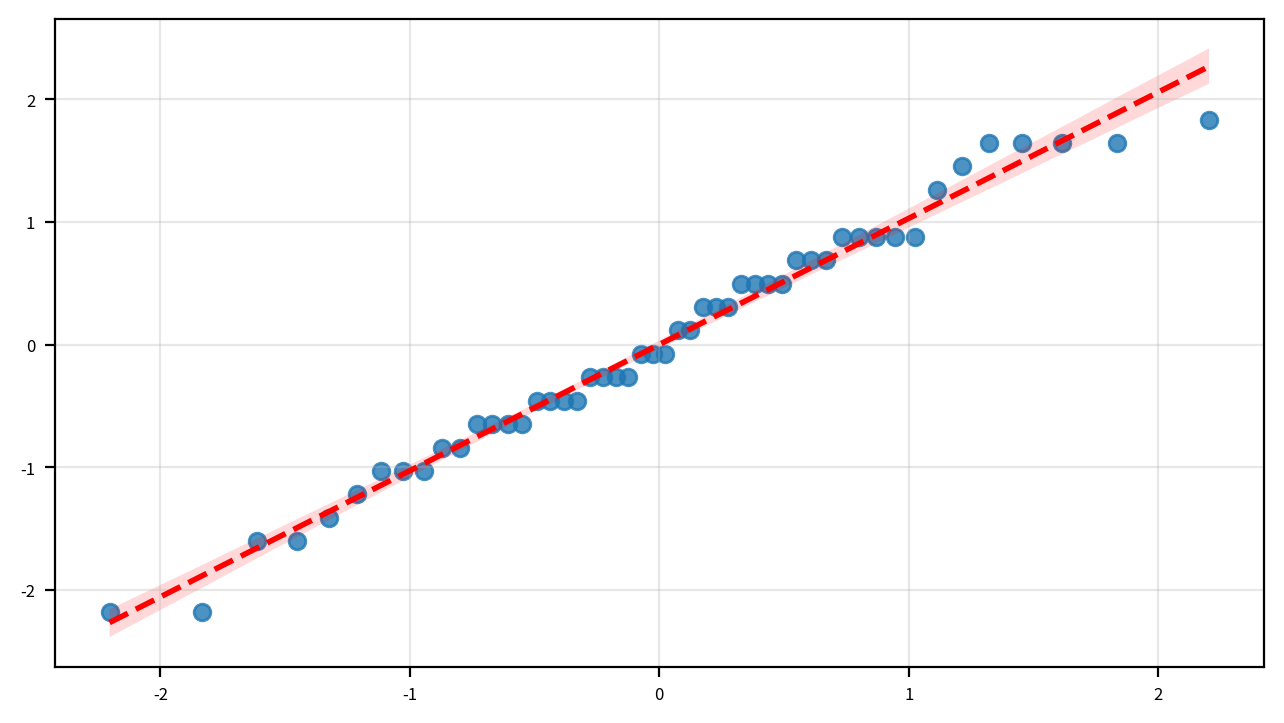

In [16]:
# 1) 그래프 초기화
width_px = 1280             # 그래프 가로 크기
height_px = 720             # 그래프 세로 크기
rows = 1                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) Reg Plot 그리기 
sb.regplot(x = x, y = y,
           line_kws = {
               'color': 'red',
               "linestyle": "--",
               "linewidth": 2
            })


# 3) 그래프 꾸미기: 
ax.grid(True, alpha=0.3)     # 배경, 격자 표시/숨김

# 4) 출력
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

> 그래도 좀 애매함

- **잔차도 그리기**
  - 1. MSE(잔차의 분산도) 구하기:

In [18]:
MSE_sq = np.sqrt(fit.mse_resid) #
r = fit.resid   #

r1 = r[(r > -MSE_sq) & (r < MSE_sq)].count() / r.count() * 100
r2 = r[(r > -2*MSE_sq) & (r < 2*MSE_sq)].count() / r.count() * 100
r3 = r[(r > -3*MSE_sq) & (r < 3*MSE_sq)].count() / r.count() * 100

mse_r = [r1, r2, r3]

print(f"루트 1MSE 구간에 포함된 잔차 비율: {r1:.2f}%")
print(f"루트 2MSE 구간에 포함된 잔차 비율: {r2:.2f}%")
print(f"루트 3MSE 구간에 포함된 잔차 비율: {r3:.2f}%")

루트 1MSE 구간에 포함된 잔차 비율: 74.00%
루트 2MSE 구간에 포함된 잔차 비율: 94.00%
루트 3MSE 구간에 포함된 잔차 비율: 100.00%


    - 2. 잔차도 시각화: .residplot()

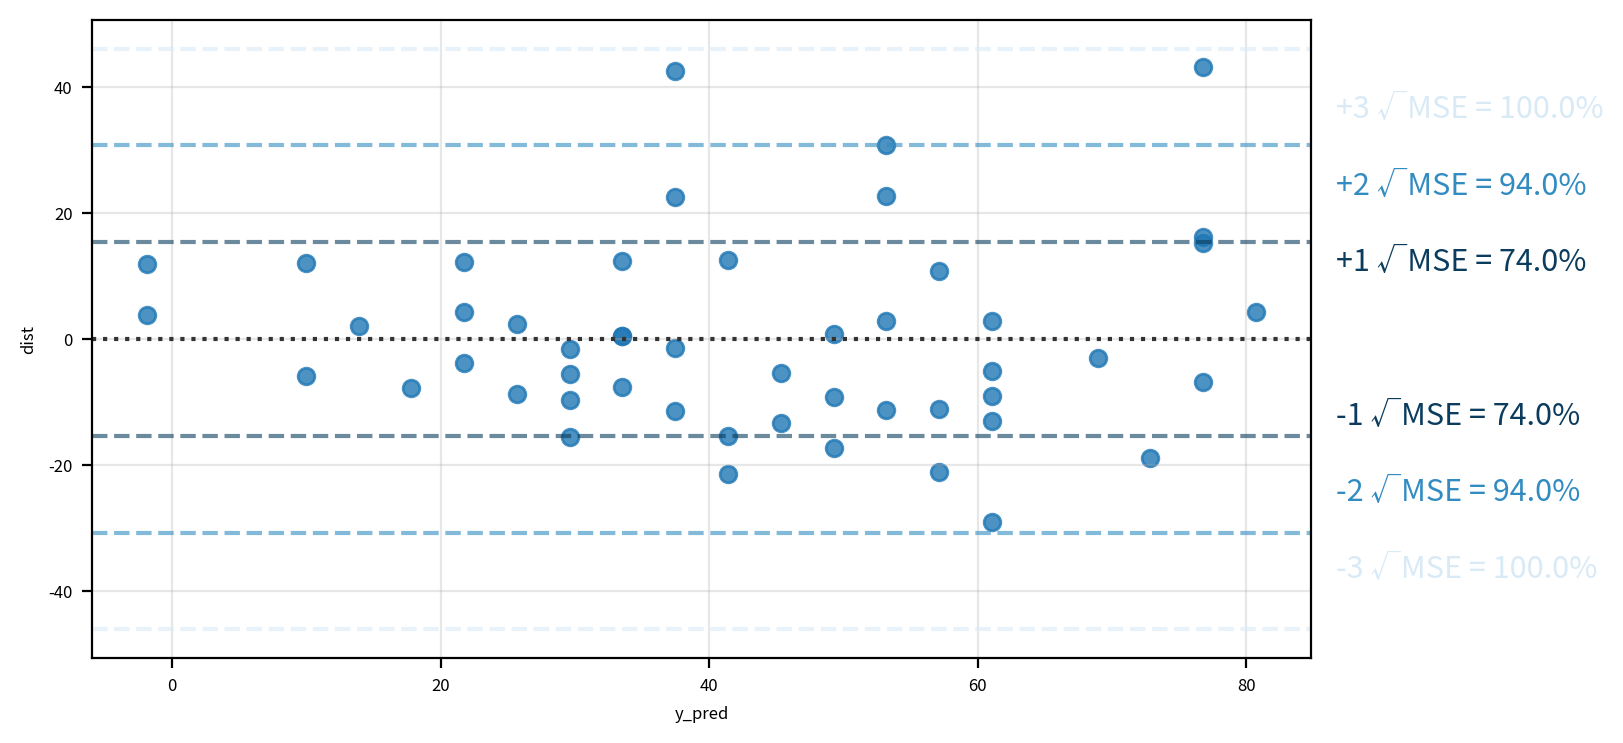

In [22]:
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
colors = ["#0B3C5D", "#328CC1", "#D9EAF7"]

xmax = df['y_pred'].max()
ymin = df['y_pred'].min()

# 1) 그래프 초기화
width_px = 1600
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi, constrained_layout=True)

# 2) seaborn 기본 잔차도
sb.residplot(data=df, x='y_pred', y="dist", ax=ax)

# 3) 꾸미기
ax.grid(True, alpha=0.3)

# 4) MSE 3단계 표시
for i, c in enumerate(colors):
    k = i + 1
    
    # 올바른 ±k√MSE 위치
    y_pos = k * mse_root
    
    ax.axhline(y= y_pos, color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)
    
    # 텍스트는 축 좌표계 사용 (그래프 밖으로 안 나감)
    ax.text(x=1.02, y=0.5 + 0.12*k,
            s=f"+{k} √MSE = {mse_r[i]}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)
    
    ax.text(x=1.02, y=0.5 - 0.12*k,
            s=f"-{k} √MSE = {mse_r[i]}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)
    
# 5) 출력
plt.show()
plt.close()


> 눈대중으론 루트 2MSE 구간이 좀 불안해보임

#### 2) 통계량을 통한 검정 

- Shapiro-Wilk(표본수 < 30) | Kolmogorov Smirnov(표본수 ≥ 30)

> 아래 예제는 표본수 50개임

In [24]:
# 샘플 수에 따라 정규성 검정 선택
if len(origin) < 30:
    method = "Shapiro-Wilk"
    s, p = shapiro(df['resid'])
else:
    method = "Kolmogorov–Smirnov"

    mu = df['resid'].mean()
    sigma = df['resid'].std(ddof=1)

    s, p = kstest(df['resid'], 'norm', args=(mu, sigma))

# 결과 문자열
result = f"{method} Test ::: statistic: {s:.3f}, p-value: {p:.3f}, {'대립' if p <=
0.05 else '귀무'}가설 채택"

print(result)

Kolmogorov–Smirnov Test ::: statistic: 0.130, p-value: 0.341, 귀무가설 채택


### 4. 잔차 등분산성 검정 - Breusch-Pagan

In [26]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

display(bp)

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

# 출력문 생성
bp_result = (
    f"Breusch–Pagan Test //: "
    f"F = {bp.loc['F Statistic','value']:.3f}, "
    f"p-value = {p_bp:.3f}, "
    f"{'대립' if p_bp <= 0.05 else '귀무'}가설 채택 → "
    f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

print(bp_result)


,value
LM Statistic,3.214880
LM p-value,0.072972
F Statistic,3.298361
F p-value,0.075597


Breusch–Pagan Test //: F = 3.298, p-value = 0.076, 귀무가설 채택 → 등분산성 만족


### 5. 잔차 독립성 - Durbin-Watson값 in 회귀분석표 하단

In [27]:
dw = durbin_watson(df['resid'])

if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(–)의 자기상관이 존재할 가능성 있음 (독립성 위반)"

print(f"Durbin–Watson = {dw:.3f} ::: {interpretation}")


Durbin–Watson = 1.676 ::: 잔차는 독립성을 만족함 (자기상관 없음)
